In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(230)

### Import data - Load MNIST Train and Test datasets 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print("Training data type: %s;\nTraining data shape: %s" % (x_train.dtype, x_train.shape))
print("\nTest data type: %s;\nTest data shape: %s" % (x_test.dtype, x_test.shape))

Training data type: uint8;
Training data shape: (60000, 28, 28)

Test data type: uint8;
Test data shape: (10000, 28, 28)


### Preprocess data

In [3]:
def preprocess_features(x, y):
    x = tf.cast(x, tf.float32)/255.0
    y = tf.cast(y, tf.int64)
    return x, y

def preprocess(x, y, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(preprocess_features)
    if mode == "train":
        ds = ds.shuffle(10000)
    ds = ds.batch(256).prefetch(1)
    return ds

In [4]:
train_ds = preprocess(x_train, y_train)
val_ds = preprocess(x_test, y_test, "test")

### Define Model

#### Option 1 - Default Sequential Model from Keras

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10)])

#### Option 2 - Custom Model inherited from Keras Model Class  

In [5]:
class Model(tf.keras.Model):

    def __init__(self, layers):
        super().__init__()
        
        self.model_layers = []
        self.model_layers.append(tf.keras.layers.Flatten(input_shape=(28,28)))
        for layer in layers:
            units = layer[0]
            activation = layer[1]
            self.model_layers.append(tf.keras.layers.Dense(units=units, activation=activation))
        self.model_layers.append(tf.keras.layers.Dense(units=10, activation=None))

    def call(self, inputs):
        outputs = inputs
        for layer in self.model_layers:
            outputs = layer(inputs)
            inputs = outputs
        return outputs

In [6]:
ls = [[100, "relu"], [100, "relu"]]
model = Model(ls)

### Define Loss and Optimizer

In [7]:
optimizer = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Training

#### Option 1 - Default Keras API using .compile and .fit

In [8]:
metrics = ["accuracy"]
epochs = 10

In [9]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Train for 235 steps, validate for 40 steps
235/235 [==============================] - 9s 39ms/step - loss: 0.4339 - accuracy: 0.8839 - val_loss: 0.1913 - val_accuracy: 0.9429


#### Option 2 - Custom Training using Gradient Tape

In [8]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [9]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, predictions)

In [10]:
@tf.function
def val_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)

    val_loss(loss)
    val_accuracy(y, predictions)

In [11]:
epochs = 10

for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    for x, y in train_ds:
        train_step(x, y)
    
    for val_x, val_y in val_ds:
        val_step(val_x, val_y)

    print('Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100))

Epoch 1, Loss: 0.43431714177131653, Accuracy: 88.27000427246094, Val Loss: 0.19948408007621765, Val Accuracy: 93.9800033569336


KeyboardInterrupt: 

### Visualization

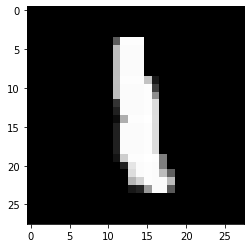

Model Prediction: 1; Correct Answer: 1


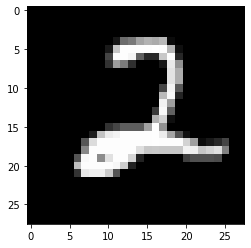

Model Prediction: 2; Correct Answer: 2


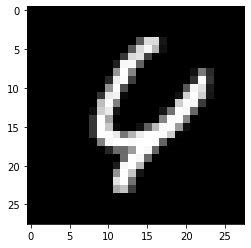

Model Prediction: 4; Correct Answer: 4


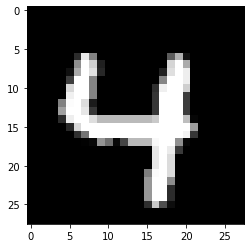

Model Prediction: 4; Correct Answer: 4


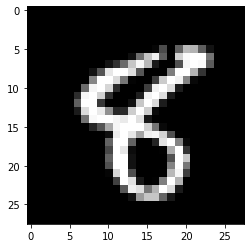

Model Prediction: 8; Correct Answer: 8


In [12]:
n_images = 5

for x, y in val_ds.take(1):
    for i in range(n_images):

        index = np.random.randint(256)
        test_image = x[index]
        predictions = model(tf.reshape(x[index], [1,28, 28]))

        plt.imshow(np.reshape(test_image, [28, 28]), cmap='gray')
        plt.show()
        print("Model Prediction: {}; Correct Answer: {}".format(np.argmax(predictions), y[index]))